In [42]:
import torch
from torch import nn 
import torchvision
from torchvision import transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
import random 
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"You are using : {device}")

You are using : cuda


In [3]:
BATCH_SIZE = 32
LR_RATE = 0.0001
NUM_EPOCHS = 20
z_dim = 128 #Bu bizim random noise değerimiz genelde 100 dür

In [29]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [ ]:
class CelebA(Dataset):
    def __init__(self, root_dir, transform=False, sample_ratio = 0.1) -> None:
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
        self.image_paths = random.sample(self.image_paths, int(len(self.image_paths) * sample_ratio)) #Orijinal veride 200000 tane veri var ben bunu 20000 e çektim
    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx) -> Image:
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image  # Etiketler yok sadece görüntüyü döndür

In [31]:
data_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"  
dataset = CelebA(root_dir=data_dir, transform=transform)
dataset

In [32]:
dataloader = DataLoader(dataset=dataset, batch_size = BATCH_SIZE, shuffle = False)
dataloader

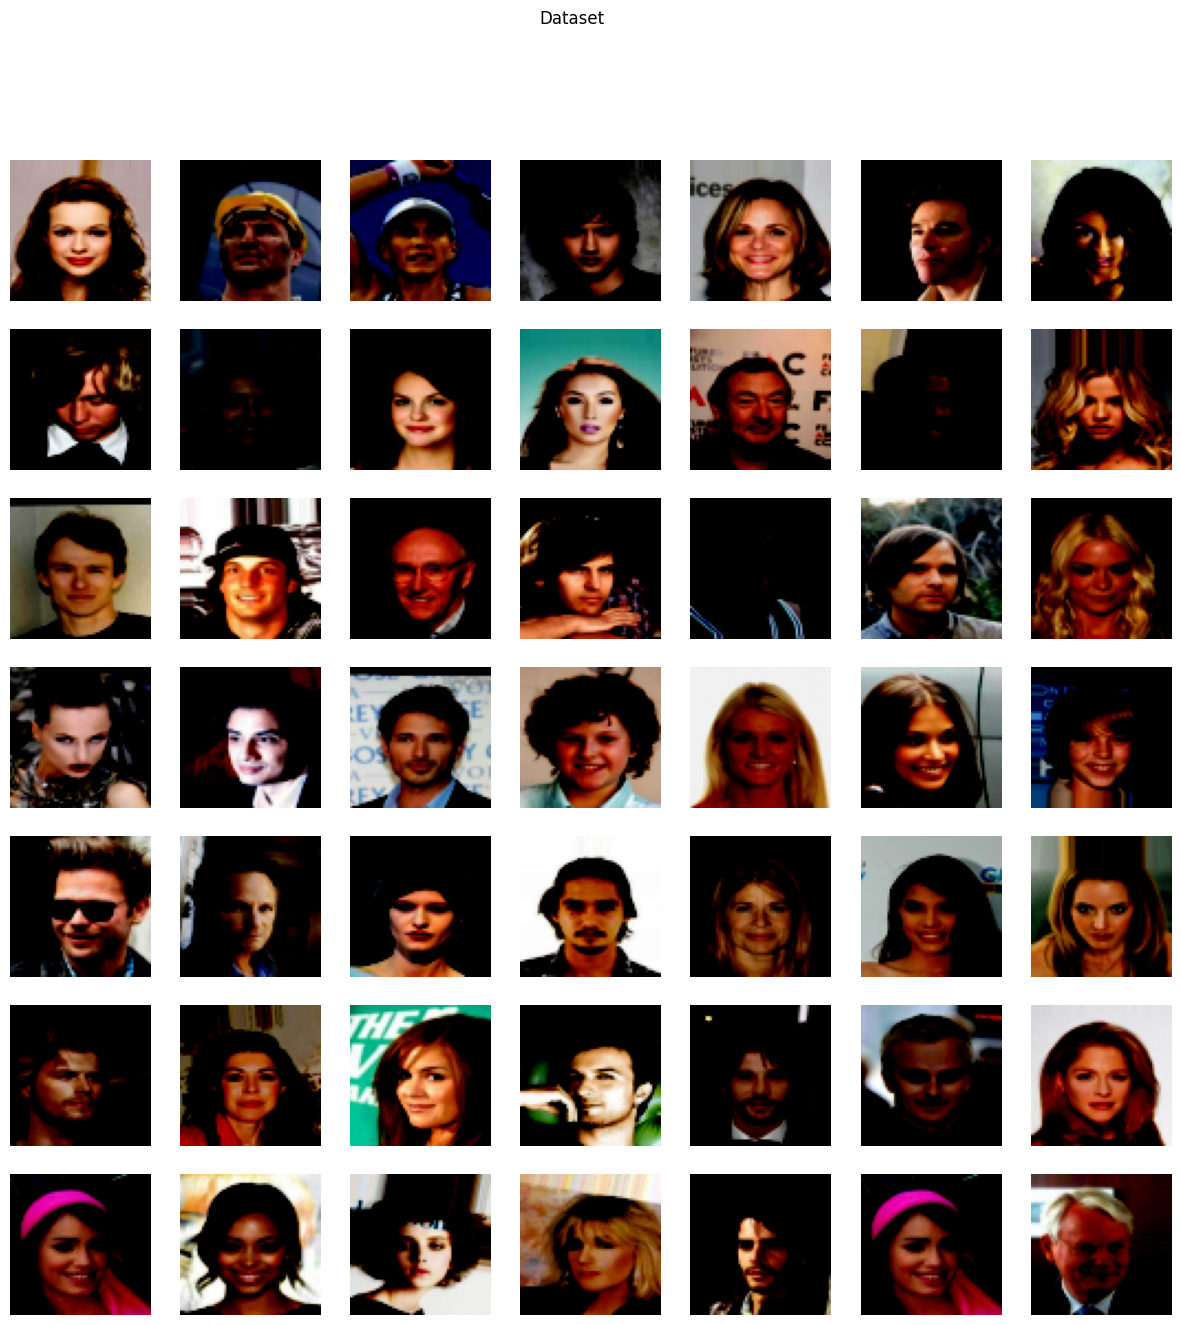

In [33]:
selected_imgs = []
for i in range(49):
    rand_num = random.randint(0, len(dataset)-1)
    selected_imgs.append(dataset[rand_num].permute(1,2,0))
fig, axes = plt.subplots(7, 7, figsize=(15, 15))

for i in range(7):
    for j in range(7):
        ax = axes[i, j]
        ax.imshow(selected_imgs[i * 7 + j]) 
        ax.axis('off') 

plt.suptitle("Dataset")
plt.show()

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim) -> None:
        super(Generator, self).__init__()
        self.gen_block = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512,3*64*64), #Resim boyutunu 64x64 olarak ayarladığımız için
            nn.Tanh()
        )
    def forward(self, z) -> torch.Tensor:
        return self.gen_block(z)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super(Discriminator, self).__init__()
        self.disc_block = nn.Sequential(
            nn.Linear(3*64*64, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img) -> torch.Tensor:
        return self.disc_block(img)

In [46]:
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

In [49]:
#Makaledeki loss a en yakını BCE Loss tur. Onun önündeki eksi katsayısı ile normal fonksiyonu minimize edeceğimize eksilisini 
#maksimize ederiz
criterion = nn.BCELoss()
#İki farklı nöral ağımız olduğu için iki farklı optimizer olması gereklidir. Makalede optimizer da momentum kullanılmıştır
optimizer_G = torch.optim.SGD(G.parameters(), lr=LR_RATE,  momentum = 0.9)
optimizer_D = torch.optim.SGD(D.parameters(), lr=LR_RATE,  momentum = 0.9)

In [51]:
writer = SummaryWriter(log_dir='runs/gan_experiment')

for epoch in range(NUM_EPOCHS):
    for index, real_img in enumerate(dataloader):
        batch_size = real_img.shape[0]
        real_img = real_img.reshape(batch_size, -1).to(device)

        #Discriminator 
        z = torch.randn(batch_size, z_dim).to(device)
        fake_img = G(z)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        D_real = D(real_img)
        D_fake = D(fake_img)
        D_loss = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

        optimizer_D.zero_grad()
        D_loss.backward(retain_graph = True)
        optimizer_D.step()

        #Generator
        G_fake = D(fake_img)
        G_loss = criterion(G_fake, real_labels)  
        
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()
    if index % 5 == 0:  
            with torch.no_grad():
                generated_images = G(z)  
            grid = make_grid(generated_images, nrow=4, normalize=True, scale_each=True)
            writer.add_image(f'Generated Images/Epoch_{epoch+1}_Batch_{index}', grid, epoch * len(dataloader) + index)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}")

Epoch [1/20], D Loss: 0.3612, G Loss: 1.3211
Epoch [2/20], D Loss: 0.2032, G Loss: 1.7733
Epoch [3/20], D Loss: 0.1619, G Loss: 1.9518
Epoch [4/20], D Loss: 0.1462, G Loss: 2.0340
Epoch [5/20], D Loss: 0.1641, G Loss: 1.9264
Epoch [6/20], D Loss: 0.1872, G Loss: 1.8576
Epoch [7/20], D Loss: 0.2266, G Loss: 1.7466
Epoch [8/20], D Loss: 0.1744, G Loss: 1.9654
Epoch [9/20], D Loss: 0.1454, G Loss: 2.1616
Epoch [10/20], D Loss: 0.1069, G Loss: 2.5697
Epoch [11/20], D Loss: 0.0716, G Loss: 3.2952
Epoch [12/20], D Loss: 0.0774, G Loss: 3.2081
Epoch [13/20], D Loss: 0.0458, G Loss: 3.4552
Epoch [14/20], D Loss: 0.0351, G Loss: 3.6140
Epoch [15/20], D Loss: 0.0448, G Loss: 3.3952
Epoch [16/20], D Loss: 0.0341, G Loss: 3.6427
Epoch [17/20], D Loss: 0.0377, G Loss: 3.8483
Epoch [18/20], D Loss: 0.0289, G Loss: 3.8741
Epoch [19/20], D Loss: 0.0247, G Loss: 4.0092
Epoch [20/20], D Loss: 0.0249, G Loss: 4.0808
